In [1]:
from mxnet import gluon

root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = '../data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}

for k, v in dataset.items():
    gluon.utils.download(root_url+k, data_dir+k, sha1_hash=v)

In [2]:
# 使用 ImageDetIter 来读取数据集，这是针对物体检测的迭代器，使用方法类似 ImageIter
# ImageDetIter 返回的不是单个图片的标号，而是每个图片里所有物体的标号，以及其对应的边框
from mxnet import image
from mxnet import nd

In [13]:
data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_classes = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200
    )
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True
    )
    return train_iter, val_iter, class_names, num_classes

In [14]:
train_data, test_data, class_names, num_classes = get_iterators(data_shape, batch_size)

batch = train_data.next()
print(batch) # label 的形状是 batch_size, num_object_per_image, 5

DataBatch: data shapes: [(32L, 3L, 256L, 256L)] label shapes: [(32L, 1L, 5L)]


In [15]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']=120
import matplotlib.pyplot as plt

In [18]:
def box_to_rect(box, color, linewidth=3):
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth
    )

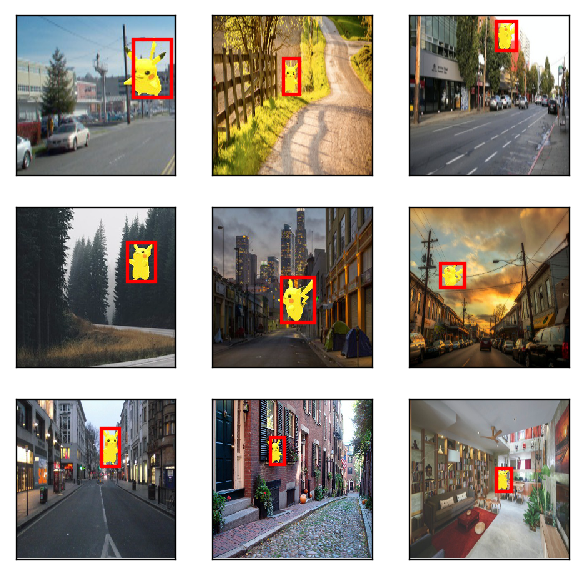

In [24]:
_, figs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0, 255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape, 'red', 2)
            fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

## SSD模型
**锚框：默认的边界框**

因为边框可以出现在图片中的任何位置，并且可以有任意大小。为了简化计算，SSD跟Faster R-CNN一样使用一些默认的边界框，或者称之为锚框（anchor box），做为搜索起点。具体来说，对输入的每个像素，以其为中心采样数个有不同形状和不同比例的边界框。假设输入大小是 w×h，

给定大小 s∈(0,1]，那么生成的边界框形状是 ws×hs
给定比例 r>0，那么生成的边界框形状是 wr√×hr√
在采样的时候我们提供 n 个大小（sizes）和 m 个比例（ratios）。为了计算简单这里不生成nm个锚框，而是n+m−1个。其中第 i 个锚框使用

sizes[i]和ratios[0] 如果 i≤n
sizes[0]和ratios[i-n] 如果 i>n
我们可以使用contribe.ndarray里的MultiBoxPrior来采样锚框。这里锚框通过左下角和右上角两个点来确定，而且被标准化成了区间[0,1]的实数。



In [25]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

In [27]:
n = 40

x = nd.random.uniform(shape=(1, 3, n, n))
y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5]) # 3 sizes, 3 ratios.

boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)

boxes[20, 20, 0, :]

(40L, 40L, 5L, 4L)



[ 0.26249999  0.26249999  0.76249999  0.76249999]
<NDArray 4 @cpu(0)>


[[ 0.26249999  0.26249999  0.76249999  0.76249999]
 [ 0.38749999  0.38749999  0.63749999  0.63749999]
 [ 0.46249998  0.46249998  0.5625      0.5625    ]
 [ 0.1589466   0.33572328  0.86605334  0.6892767 ]
 [ 0.33572328  0.1589466   0.6892767   0.86605334]]
<NDArray 5x4 @cpu(0)>


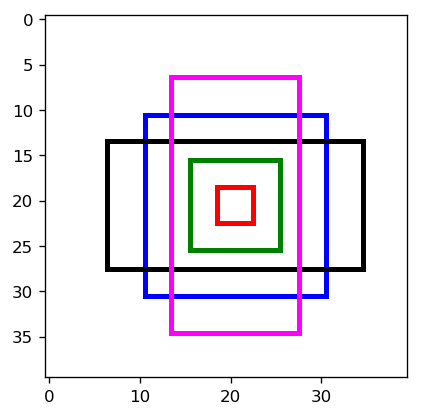

In [33]:
colors = ['blue', 'green', 'red', 'black', 'magenta']
# 画出以(20,20)为中心的所有锚框
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
print(anchors)
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i, :]*n, colors[i]))
plt.show()

## 预测物体类别
对每一个锚框我们需要预测它是不是包含了我们感兴趣的物体，还是只是背景。这里我们使用一个3×3的卷积层来做预测，加上pad=1使用它的输出和输入一样。同时输出的通道数是num_anchors*(num_classes+1)，每个通道对应一个锚框对某个类的置信度。假设输出是Y，那么对应输入中第n个样本的第(i,j)像素的置信值是在Y[n,:,i,j]里。具体来说，对于以(i,j)为中心的第a个锚框，

* 通道 a*(num_class+1) 是其只包含背景的分数
* 通道 a*(num_class+1)+1+b 是其包含第b个物体的分数

In [35]:
# 定义个一个这样的类别分类器函数
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """ return a layer to predict classes"""
    return nn.Conv2D(num_anchors*(num_classes+1), 3, padding=1)
cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = cls_pred(x)
y.shape

(2L, 55L, 20L, 20L)

## 预测边界框
因为真实的边界框可以是任意形状，我们需要预测如何从一个锚框变换成真正的边界框。这个变换可以由一个长为4的向量来描述。同上一样，我们用一个有num_anchors * 4通道的卷积。假设输出是Y，那么对应输入中第 n 个样本的第 (i,j) 像素为中心的锚框的转换在Y[n,:,i,j]里。具体来说，对于第a个锚框，它的变换在a*4到a*4+3通道里

In [36]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors*4, 3, padding=1)
box_pred = box_predictor(10) # 10 个 anchors
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = box_pred(x)
y.shape

(2L, 40L, 20L, 20L)

## 减半模块
我们定义一个卷积块，它将输入特征的长宽减半，以此来获取多尺度的预测。它由两个Conv-BatchNorm-Relu组成，我们使用填充为1的3×3卷积使得输入和输入有同样的长宽，然后再通过跨度为2的最大池化层将长宽减半。

In [37]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, padding=1, strides=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(pool_size=2))
    return out

In [38]:
blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
y = blk(x)
y.shape

(2L, 10L, 10L, 10L)

## 合并来自不同层的预测输出
前面我们提到过SSD的一个重要性质是它会在多个层同时做预测。每个层由于长宽和锚框选择不一样，导致输出的数据形状会不一样。这里我们用物体类别预测作为样例，边框预测是类似的。

我们首先创建一个特定大小的输入，然后对它输出类别预测。然后对输入减半，再输出类别预测。

In [39]:

x = nd.zeros((2, 8, 20, 20))
print('x:', x.shape)

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(x)
print('Class prediction 1:', y1.shape)

ds = down_sample(16)
ds.initialize()
x = ds(x)
print('x:', x.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(x)
print('Class prediction 2:', y2.shape)

('x:', (2L, 8L, 20L, 20L))
('Class prediction 1:', (2L, 55L, 20L, 20L))
('x:', (2L, 16L, 10L, 10L))
('Class prediction 2:', (2L, 33L, 10L, 10L))


为了之后处理简单，我们将不同层的输入合并成一个输出。首先我们将通道移到最后的维度，然后将其展成2D数组。因为第一个维度是样本个数，所以不同输出之间是不变，我们可以将所有输出在第二个维度上拼接起来。

In [42]:
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()
def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

In [43]:
flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
y = concat_predictions([flat_y1, flat_y2])
print('Concat class predictions', y.shape)

('Flatten class prediction 1', (2L, 22000L))
('Flatten class prediction 2', (2L, 3300L))
('Concat class predictions', (2L, 25300L))


## 主体网络
主体网络用来从原始像素抽取特征。通常前面介绍的用来图片分类的卷积神经网络，例如ResNet，都可以用来作为主体网络。这里为了示范，我们简单叠加几个减半模块作为主体网络。

In [44]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.random.uniform(shape=(2,3,256,256))
y = bnet(x)
y.shape

(2L, 64L, 32L, 32L)

## 创建一个玩具SSD模型
现在我们可以创建一个玩具SSD模型了。我们称之为玩具是因为这个网络不管是层数还是锚框个数都比较小，仅仅适合之后我们之后使用的一个小数据集。但这个模型不会影响我们介绍SSD。

这个网络包含四块。主体网络，三个减半模块，以及五个物体类别和边框预测模块。其中预测分别应用在在主体网络输出，减半模块输出，和最后的全局池化层上。

In [46]:
def toy_ssd_model(num_anchors, num_classes):
    
    downsamplers = nn.Sequential() # 减半模块
    for _ in range(3):
        downsamplers.add(down_sample(128))

    class_predictors = nn.Sequential() # 5 个物体类别预测模块
    box_predictors = nn.Sequential()   # 5 个边框预测模块
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))
        
    model = nn.Sequential() # 主体网络
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

In [49]:
# 计算预测
# 给定模型和每层预测输出所使用的锚框的大小和形状，定义 forward 函数
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction
    x = body(x)
    for i in range(5):
        anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(flatten_prediction(class_predictors[i](x)))
        box_preds.append(flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', anchors[-1].shape[1], 'anchors')
        # downsample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max',
                kernel=(x.shape[2], x.shape[3])
            )
    # concat data
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

In [53]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [
            [.2, .272],
            [.37, .447],
            [.54, .619],
            [.71, .79],
            [.88, .961]
        ]
        self.ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes
        self.verbose = verbose
        
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use namescope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)
    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, verbose=self.verbose
        )
        class_preds, = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

In [60]:
net = ToySSD(num_classes=2, verbose=True)
net.initialize()
x = batch.data[0][0:1] # data[0] 表示 data batch 的 第一个元素：batch_size个样本
# print(batch.data[0].shape)
print(x.shape)
anchors, class_preds, box_preds = net(x)
print(anchors.shape, class_preds.shape, box_preds.shape)

(1L, 3L, 256L, 256L)
('Predict scale', 0, (1L, 64L, 32L, 32L), 'with', 4096L, 'anchors')
('Predict scale', 1, (1L, 128L, 16L, 16L), 'with', 1024L, 'anchors')
('Predict scale', 2, (1L, 128L, 8L, 8L), 'with', 256L, 'anchors')
('Predict scale', 3, (1L, 128L, 4L, 4L), 'with', 64L, 'anchors')
('Predict scale', 4, (1L, 128L, 1L, 1L), 'with', 4L, 'anchors')
((1L, 5444L, 4L), (5444L, 3L), (1L, 21776L))


对于分类问题，使用交叉熵来计算损失
在回归任务中，例如这里我们需要检测边框，引入 IoU
## 损失函数
虽然每张图片里面通常只有几个标注的边框，但SSD会生成大量的锚框。可以想象很多锚框都不会框住感兴趣的物体，就是说跟任何对应感兴趣物体的表框的IoU都小于某个阈值。这样就会产生大量的负类锚框，或者说对应标号为0的锚框。对于这类锚框有两点要考虑的：

边框预测的损失函数不应该包括负类锚框，因为它们并没有对应的真实边框
因为负类锚框数目可能远多于其他，我们可以只保留其中的一些。而且是保留那些目前预测最不确信它是负类的，就是对类0预测值排序，选取数值最小的哪一些困难的负类锚框。

In [62]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

out = training_targets(anchors, class_preds, batch.label[0][0:1])
out

MXNetError: [11:13:45] src/operator/tensor/./matrix_op-inl.h:310: Check failed: shp.ndim() == param.axes.ndim() (2 vs. 3) 

Stack trace returned 8 entries:
[bt] (0) 0   libmxnet.so                         0x0000000110b872cf libmxnet.so + 58063
[bt] (1) 1   libmxnet.so                         0x0000000110b8706f libmxnet.so + 57455
[bt] (2) 2   libmxnet.so                         0x0000000111a27366 libmxnet.so + 15393638
[bt] (3) 3   libmxnet.so                         0x0000000111b8e427 MXNDListFree + 420935
[bt] (4) 4   libmxnet.so                         0x0000000111b8d029 MXNDListFree + 415817
[bt] (5) 5   libmxnet.so                         0x0000000111b0f277 MXCustomFunctionRecord + 16119
[bt] (6) 6   libmxnet.so                         0x0000000111b10444 MXImperativeInvokeEx + 164
[bt] (7) 7   libffi.6.dylib                      0x000000010eaca884 ffi_call_unix64 + 76



对于分类问题，最常用的损失函数是之前一直使用的交叉熵。这里我们定义一个类似于交叉熵的损失，不同于交叉熵的定义 log(pj)，这里 j 是真实的类别，且 pj 是对于的预测概率。我们使用一个被称之为关注损失的函数，给定正的γ和α，它的定义是

−α(1−pj)γlog(pj)


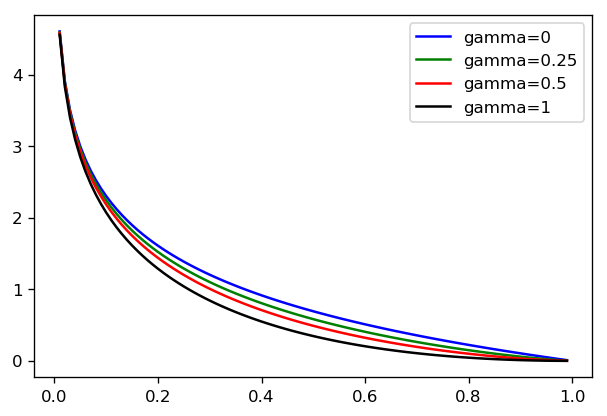

In [63]:
import numpy as np

def focal_loss(gamma, x):
    # set alpha to 1.
    return -(1-x)**gamma*np.log(x)

x = np.arange(0.01, 1, .01)
gammas = [0, .25, .5, 1]
for i, g in enumerate(gammas):
    plt.plot(x, focal_loss(g, x), colors[i])
plt.legend(['gamma='+str(g) for g in gammas])
plt.show()

In [66]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma
    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1-pj)**self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)

In [67]:
cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

边框的预测是一个回归问题。通常可以选择平方损失函数（L2损失）f(x)=x2。但这个损失对于比较大的误差的惩罚很高。我们可以采用稍微缓和一点绝对损失函数（L1损失）f(x)=|x|，它是随着误差线性增长，而不是平方增长。但这个函数在0点处导数不唯一，因此可能会影响收敛。一个通常的解决办法是在0点附近使用平方函数使得它更加平滑。它被称之为平滑L1损失函数。它通过一个参数σ来控制平滑的区域：

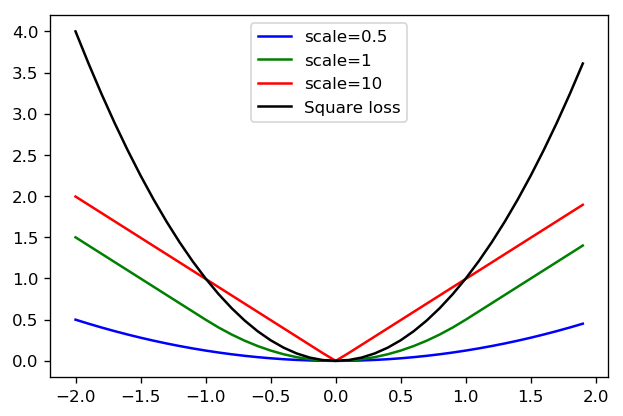

In [68]:
scales = [.5, 1, 10]
x = nd.arange(-2, 2, 0.1)

for i,s in enumerate(scales):
    y = nd.smooth_l1(x, scalar=s)
    plt.plot(x.asnumpy(), y.asnumpy(), color=colors[i])
plt.plot(x.asnumpy(), (x**2).asnumpy(), color=colors[len(scales)])
plt.legend(['scale='+str(s) for s in scales]+['Square loss'])
plt.show()

In [69]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output-label)*mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)
box_loss = SmoothL1Loss()
box_loss

SmoothL1Loss(batch_axis=0, w=None)

In [70]:
from mxnet import metric

In [71]:
cls_metric = metric.Accuracy()
box_metric = metric.MAE()

In [72]:
# 初始化模型和训练器
from mxnet import init
from mxnet import gpu

ctx = gpu(0)

train_data.reshape(label_shape=(3, 5))
train_data = test_data.sync_label_shape(train_data)

net = ToySSD(num_classes)
net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.1, 'wd':5e-4})

MXNetError: [11:54:08] src/ndarray/ndarray.cc:596: GPU is not enabled

Stack trace returned 10 entries:
[bt] (0) 0   libmxnet.so                         0x0000000110b872cf libmxnet.so + 58063
[bt] (1) 1   libmxnet.so                         0x0000000110b8706f libmxnet.so + 57455
[bt] (2) 2   libmxnet.so                         0x0000000111c62cbc MXNDListFree + 1291484
[bt] (3) 3   libmxnet.so                         0x0000000111b9b5cd MXNDListFree + 474605
[bt] (4) 4   libmxnet.so                         0x0000000111b89ff2 MXNDListFree + 403474
[bt] (5) 5   libmxnet.so                         0x0000000111b88a8c MXNDListFree + 397996
[bt] (6) 6   libmxnet.so                         0x0000000111b8d07a MXNDListFree + 415898
[bt] (7) 7   libmxnet.so                         0x0000000111b0f277 MXCustomFunctionRecord + 16119
[bt] (8) 8   libmxnet.so                         0x0000000111b10444 MXImperativeInvokeEx + 164
[bt] (9) 9   libffi.6.dylib                      0x000000010eaca884 ffi_call_unix64 + 76



In [74]:
import tim
from mxnet import autograd
train_data.reset()
cls_metric.reset()
box_metric.reset()
tic = time.time()
for i, batch in enumerate(train_data):
    x = batch.data[0].as_in_context(ctx)
    y = batch.label[0].as_in_context(ctx)
    with autograd.record():
        anchors, class_preds, box_preds = net(x)
        box_target, box_mask, cls_target = training_targets(anchors, class_preds, y)
        # losses
        loss1 = cls_loss(class_preds, cls_target)
        loss2 = box_loss(box_preds, box_target, box_mask)
        loss = loss1+loss2
    loss.backward()
    trainer.step(batch_size)
    # update metrics
    cls_metric.update([cls_target], [class_preds.transpose((0, 2, 1))])
    box_metric.update([box_target], [box_preds*box_mask])
    
    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (epoch, *cls_metric.get(), *box_metric.get(), time.time()-tic))

SyntaxError: invalid syntax (<ipython-input-74-75cfb111e9d8>, line 23)

## 预测


In [75]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), im

训练那样预测表框和其对应的物体。但注意到因为我们对每个像素都会生成数个锚框，这样我们可能会预测出大量相似的表框，从而导致结果非常嘈杂。一个办法是对于IoU比较高的两个表框，我们只保留预测执行度比较高的那个。

In [ ]:
# non maximum suppression 在 MultiBoxDetection 里实现了
from mxnet.contrib.ndarray import MultiBoxDetection
def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
    return MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False)

In [ ]:
x, im = process_image('../img/pikachu.jpg')
out = predict(x)
out.shape

In [ ]:
def display(im, out, threshold=0.5):
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)

        text = class_names[class_id]
        plt.gca().text(box[0], box[1],
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.5)
